### Step 1: Define the Custom Dataset Class `ChestXrayDataset`

This section defines a custom PyTorch `Dataset` class to load chest X-ray images from the DA and DB datasets. The dataset includes images in two formats: `.jpg` and `.dcm` (DICOM format). 

Key steps in the `ChestXrayDataset` class:
- **Data Source**: Images are loaded from two folders: `images/da` and `images/db`.
- **Label Extraction**: 
  - Images starting with `n` are labeled **0** (TB Negative).
  - Images starting with `p` are labeled **1** (TB Positive).
- **DICOM Handling**: 
  - DICOM images are normalized to the 0-255 range and converted into 8-bit RGB format.
- **Transformations**: 
  - Images are optionally resized and normalized during loading if a transform is provided.

This dataset class prepares the data for further processing in the model training and evaluation pipeline.


In [2]:
pip install pydicom

   ---------------------------------------- 0.0/2.4 MB ? eta -:--:--
   ----------------------------------- ---- 2.1/2.4 MB 19.7 MB/s eta 0:00:01
   ---------------------------------------- 2.4/2.4 MB 13.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
pip install torch torchvision torchaudio

Note: you may need to restart the kernel to use updated packages.Collecting torch
   ---------------------------------------- 0.0/110.9 MB ? eta -:--:--
    --------------------------------------- 2.6/110.9 MB 16.7 MB/s eta 0:00:07
   -- ------------------------------------- 7.3/110.9 MB 21.3 MB/s eta 0:00:05
   ---- ----------------------------------- 13.1/110.9 MB 23.0 MB/s eta 0:00:05
   ------ --------------------------------- 19.4/110.9 MB 24.6 MB/s eta 0:00:04
   --------- ------------------------------ 26.0/110.9 MB 25.9 MB/s eta 0:00:04
   ----------- ---------------------------- 32.0/110.9 MB 26.3 MB/s eta 0:00:04
   ------------- -------------------------- 38.3/110.9 MB 27.4 MB/s eta 0:00:03
   --------------- ------------------------ 44.0/110.9 MB 27.0 MB/s eta 0:00:03
   ----------------- ---------------------- 49.3/110.9 MB 26.9 MB/s eta 0:00:03
   ------------------- -------------------- 55.3/110.9 MB 27.1 MB/s eta 0:00:03
   --------------------- ------------------ 60.0/


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
pip install kagglehub

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download(
    "yasserhessein/tuberculosis-chest-x-rays-images"
)

print("Path to dataset files:", path)


100%|██████████| 26.3M/26.3M [00:04<00:00, 6.04MB/s]

Extracting files...


Path to dataset files: C:\Users\aryas\.cache\kagglehub\datasets\yasserhessein\tuberculosis-chest-x-rays-images\versions\2


In [10]:
import os

print(os.listdir(path))

['Dataset of Tuberculosis Chest X-rays Images']


In [12]:
print(os.listdir(os.path.join(path, "Dataset of Tuberculosis Chest X-rays Images")))

['Normal Chest X-rays', 'TB Chest X-rays']


In [ ]:
#Import necessary libraries
import os
from torch.utils.data import Dataset
from PIL import Image
import pydicom
import torch
import numpy as np

#Define ChestXrayDataset
class ChestXrayDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.transform = transform
        self.samples = []

        base_path = os.path.join(
            root_dir,
            "Dataset of Tuberculosis Chest X-rays Images"
        )

        normal_path = os.path.join(base_path, "Normal Chest X-rays")
        tb_path = os.path.join(base_path, "TB Chest X-rays")

        # Normal images → label 0
        for file in os.listdir(normal_path):
            if file.lower().endswith(('.jpg', '.jpeg', '.png', '.dcm')):
                self.samples.append(
                    (os.path.join(normal_path, file), 0)
                )

        # TB images → label 1
        for file in os.listdir(tb_path):
            if file.lower().endswith(('.jpg', '.jpeg', '.png', '.dcm')):
                self.samples.append(
                    (os.path.join(tb_path, file), 1)
                )

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]

        if img_path.endswith(".dcm"):
            dicom = pydicom.dcmread(img_path)
            image = dicom.pixel_array
            image = Image.fromarray(image).convert("RGB")
        else:
            image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long)


In [14]:
dataset = ChestXrayDataset(
    root_dir=path,
    transform=transform
)

print("Total images:", len(dataset))

Total images: 3008


In [5]:
# 1. Import necessary libraries
import os
import pydicom
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms

# 2. Define ChestXrayDataset
class ChestXrayDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        da_path = os.path.join(root_dir, 'images', 'da')
        db_path = os.path.join(root_dir, 'images', 'db')

        # Gather all image paths from both DA and DB folders
        for folder in [da_path, db_path]:
            for filename in os.listdir(folder):
                if filename.endswith('.jpg') or filename.endswith('.dcm'):
                    full_path = os.path.join(folder, filename)
                    self.image_paths.append(full_path)

                    # Extract true filename without train_/test_/da_/db_ prefix
                    parts = filename.split('_')
                    true_filename = parts[-1]  # Always take last part

                    if true_filename.startswith('n') or 'n' in true_filename[:2]:
                        self.labels.append(0)  # TB Negative
                    elif true_filename.startswith('p') or 'p' in true_filename[:2]:
                        self.labels.append(1)  # TB Positive
                    else:
                        raise ValueError(f"Unexpected filename format: {filename}")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
    
        if img_path.endswith('.jpg'):
            image = Image.open(img_path).convert('RGB')
    
        elif img_path.endswith('.dcm'):
            dicom = pydicom.dcmread(img_path)
            img_array = dicom.pixel_array
    
            # Normalize and convert to uint8
            img_array = img_array.astype(np.float32)  # Convert to float
            img_array = (img_array - np.min(img_array)) / (np.max(img_array) - np.min(img_array))  # Normalize to [0,1]
            img_array = (img_array * 255).astype(np.uint8)  # Scale to [0,255] and convert to uint8
    
            img_array = np.stack((img_array,)*3, axis=-1)  # Make it 3-channel (RGB)
            image = Image.fromarray(img_array)
    
        else:
            raise ValueError(f"Unsupported file format: {img_path}")
    
        if self.transform:
            image = self.transform(image)
    
        return image, label



### Step 2: Define Image Transformations

Before feeding images into the model, basic preprocessing transformations are applied:

- **Resize**: Images are resized to `224x224` pixels to match the expected input size for ResNet18.
- **ToTensor**: Images are converted from PIL format into PyTorch tensors.
- **Normalize**: Pixel values are normalized with a mean of `0.5` and a standard deviation of `0.5`. 
  - This scales pixel intensities from [0,1] to approximately [-1,1], which helps improve model training stability.

These transformations ensure consistency across the dataset and help the model generalize better.


In [6]:
# Define basic transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),          # Convert image to PyTorch Tensor
    transforms.Normalize([0.5], [0.5])  # Normalize to mean=0.5, std=0.5
])


### Step 3: Create Dataset Instances and DataLoaders

After defining the dataset and transformations, the dataset is prepared for training and validation:

- **Dataset Instance**: 
  - `ChestXrayDataset` is instantiated using the root directory and the defined transformations.
- **Train-Validation Split**:
  - The dataset is split into **80% training** and **20% validation** subsets using `random_split`.
- **DataLoaders**:
  - `train_loader` and `val_loader` are created to efficiently load batches of images during training and validation.
  - Training DataLoader uses `shuffle=True` to ensure random batches during training.
  - Validation DataLoader uses `shuffle=False` for consistent evaluation.

DataLoaders enable efficient mini-batch training and evaluation on the GPU or CPU.


In [15]:
from torch.utils.data import random_split

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(
    dataset, [train_size, val_size]
)

In [16]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    train_dataset, batch_size=16, shuffle=True
)

val_loader = DataLoader(
    val_dataset, batch_size=16, shuffle=False
)

print(f"Training images: {len(train_dataset)}")
print(f"Validation images: {len(val_dataset)}")

Training images: 2406
Validation images: 602


### Step 4: Define and Customize the Deep Learning Model (ResNet18)

In this step, a deep learning model is prepared for TB classification:

- **Pretrained Model**: 
  - ResNet18 pretrained on ImageNet is loaded using `ResNet18_Weights.DEFAULT`.
- **Freezing Layers**:
  - Early layers of the network are frozen to retain previously learned features and speed up training.
- **Custom Fully Connected Layer**:
  - The original fully connected (fc) layer is replaced with:
    - A `Linear` layer reducing features to 128 dimensions.
    - A `ReLU` activation.
    - A `Dropout` layer (to prevent overfitting).
    - A final `Linear` layer with 1 neuron followed by a `Sigmoid` activation for binary classification (TB Positive or Negative).
- **Device Assignment**:
  - The model is moved to GPU if available, otherwise it uses CPU.

This setup enables efficient fine-tuning of a strong feature extractor (ResNet18) specifically for the TB classification task.


In [17]:
import torch.nn as nn
import torchvision.models as models

# Load a pre-trained ResNet18
from torchvision.models import ResNet18_Weights

model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
# Freeze early layers (optional for faster training)
for param in model.parameters():
    param.requires_grad = False

# Replace the final fully connected (fc) layer
num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_features, 128),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(128, 1),  # 1 output neuron (binary classification)
    nn.Sigmoid()        # To output probability between 0 and 1
)

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

print(model)


2.2%

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\aryas/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


100.0%


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Step 5: Define the Training Loop

This section defines the `train_model` function, which handles the complete training and validation process:

- **Timing**:
  - The training duration is recorded for reporting.
- **Model States**:
  - The model alternates between `train()` and `eval()` modes depending on the phase (training or validation).
- **Loss Tracking**:
  - Training and validation losses are computed and stored for each epoch.
- **Gradient Updates**:
  - During the training phase, gradients are computed and the optimizer updates model weights.
- **Best Model Tracking**:
  - The model's weights achieving the lowest validation loss are saved during training.
- **Learning Rate Scheduler**:
  - The learning rate is adjusted periodically to help improve convergence.
- **Return Values**:
  - The function returns the best-performing model and lists of training and validation losses for further analysis.

This structure ensures the model is properly trained, monitored, and optimized over the specified number of epochs.


In [18]:
import time
import copy

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=15):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 30)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                loader = train_loader
            else:
                model.eval()   # Set model to evaluate mode
                loader = val_loader

            running_loss = 0.0

            # Iterate over data
            for inputs, labels in loader:
                inputs = inputs.to(device)
                labels = labels.to(device).float().unsqueeze(1)  # Make sure labels are float and have shape [batch_size,1]

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / len(loader.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f}')

            if phase == 'train':
                train_losses.append(epoch_loss)
            else:
                val_losses.append(epoch_loss)

                # Deep copy the model if it has better val loss
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())

        scheduler.step()
        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Loss: {best_loss:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)

    return model, train_losses, val_losses


### Step 6: Configure the Training Parameters and Start Training

This step sets up the key components required for training the model:

- **Loss Function**:
  - `BCELoss` (Binary Cross-Entropy Loss) is used because this is a binary classification task (TB Positive vs. TB Negative).
- **Optimizer**:
  - `Adam` optimizer is used to update model weights, focusing only on the new classifier layers (`model.fc.parameters()`).
- **Learning Rate Scheduler**:
  - A `StepLR` scheduler reduces the learning rate by a factor of 0.1 every 5 epochs, helping to refine training and avoid overshooting minima.
- **Number of Epochs**:
  - The model is trained for 15 epochs.
- **Training Execution**:
  - The `train_model` function is called to initiate the training process using the defined criterion, optimizer, and scheduler.

This setup ensures efficient training, faster convergence, and better generalization of the model.


In [19]:
import torch.optim as optim

# Define Loss Function
criterion = nn.BCELoss()

# Define Optimizer (training only the classifier layers)
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

# Define Learning Rate Scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Set number of epochs
num_epochs = 15

# Now Train the Model
model, train_losses, val_losses = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=num_epochs
)


Epoch 1/15
------------------------------
train Loss: 0.1651
val Loss: 0.0348

Epoch 2/15
------------------------------
train Loss: 0.0608
val Loss: 0.0254

Epoch 3/15
------------------------------
train Loss: 0.0440
val Loss: 0.0295

Epoch 4/15
------------------------------
train Loss: 0.0502
val Loss: 0.0190

Epoch 5/15
------------------------------
train Loss: 0.0420
val Loss: 0.0220

Epoch 6/15
------------------------------
train Loss: 0.0242
val Loss: 0.0116

Epoch 7/15
------------------------------
train Loss: 0.0293
val Loss: 0.0124

Epoch 8/15
------------------------------
train Loss: 0.0260
val Loss: 0.0100

Epoch 9/15
------------------------------
train Loss: 0.0284
val Loss: 0.0238

Epoch 10/15
------------------------------
train Loss: 0.0188
val Loss: 0.0075

Epoch 11/15
------------------------------
train Loss: 0.0218
val Loss: 0.0091

Epoch 12/15
------------------------------
train Loss: 0.0156
val Loss: 0.0100

Epoch 13/15
------------------------------
train 

### Step 7: Define Single Image Prediction Function

This function enables prediction of Tuberculosis (TB) status for a single uploaded chest X-ray image:

- **Input Parameters**:
  - `model`: The trained PyTorch model.
  - `image_path`: Path to the input image (.jpg or .dcm).
  - `transform`: The preprocessing transformations applied during training.
  - `device`: The device (CPU or GPU) where the model is loaded.

- **Image Loading**:
  - If the image is `.jpg`, it is loaded and converted to RGB.
  - If the image is `.dcm` (DICOM format), it is read using `pydicom`, normalized, converted to 8-bit RGB format.

- **Preprocessing**:
  - The loaded image undergoes resizing, normalization, and conversion to a tensor, similar to the training phase.

- **Prediction**:
  - The model outputs a probability score.
  - A threshold of 0.5 is applied to determine whether the image is predicted as **TB Positive** or **TB Negative**.

- **Output**:
  - Returns the predicted label and the probability associated with the prediction.

This function enables real-world testing where users can upload X-ray images and get instant TB detection results.


In [20]:
def predict_tb_from_image(model, image_path, transform, device):
    model.eval()

    # Load image
    if image_path.endswith('.jpg'):
        image = Image.open(image_path).convert('RGB')
    elif image_path.endswith('.dcm'):
        dicom = pydicom.dcmread(image_path)
        img_array = dicom.pixel_array

        # Normalize and convert
        img_array = img_array.astype(np.float32)
        img_array = (img_array - np.min(img_array)) / (np.max(img_array) - np.min(img_array))
        img_array = (img_array * 255).astype(np.uint8)
        img_array = np.stack((img_array,)*3, axis=-1)
        image = Image.fromarray(img_array)
    else:
        raise ValueError(f"Unsupported file format: {image_path}")

    # Apply same transform
    image = transform(image).unsqueeze(0)  # Add batch dimension

    image = image.to(device)

    # Predict
    with torch.no_grad():
        output = model(image)
        probability = output.item()
        prediction = 1 if probability >= 0.5 else 0

    label = "TB Positive" if prediction == 1 else "TB Negative"

    return label, probability


In [21]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def evaluate_model(model, val_loader, device):
    model.eval()
    preds = []
    probs = []
    labels = []

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.to(device)
            targets = targets.to(device).float().unsqueeze(1)

            outputs = model(inputs)
            probs_batch = outputs.squeeze().cpu().numpy()
            preds_batch = (probs_batch >= 0.5).astype(int)

            preds.extend(preds_batch)
            probs.extend(probs_batch)
            labels.extend(targets.cpu().numpy())

    preds = np.array(preds)
    probs = np.array(probs)
    labels = np.array(labels)

    return preds, probs, labels

# Now evaluate
preds, probs, true_labels = evaluate_model(model, val_loader, device)


### Step 8: Evaluate Model on Validation Set

This step defines the evaluation procedure for assessing model performance on the validation dataset:

- **Function `evaluate_model`**:
  - The model is set to evaluation mode using `model.eval()`.
  - Predictions (`preds`), predicted probabilities (`probs`), and true labels (`labels`) are collected across the validation set without updating model weights (`torch.no_grad()`).

- **Processing**:
  - Inputs are passed through the model.
  - Outputs (probabilities) are thresholded at 0.5 to obtain binary class predictions (0 = TB Negative, 1 = TB Positive).
  - All predictions, probabilities, and ground truths are gathered into NumPy arrays for further evaluation.

- **Return Values**:
  - `preds`: Final predicted labels (0 or 1).
  - `probs`: Probability scores between 0 and 1.
  - `labels`: Actual ground truth labels.

This function enables calculation of key performance metrics such as Accuracy, Precision, Recall, F1-Score, Confusion Matrix, and ROC Curve for validating model performance.


Validation Accuracy: 0.7196

Classification Report:
              precision    recall  f1-score   support

 TB Negative       0.99      1.00      1.00       101
 TB Positive       1.00      1.00      1.00       501

    accuracy                           1.00       602
   macro avg       1.00      1.00      1.00       602
weighted avg       1.00      1.00      1.00       602



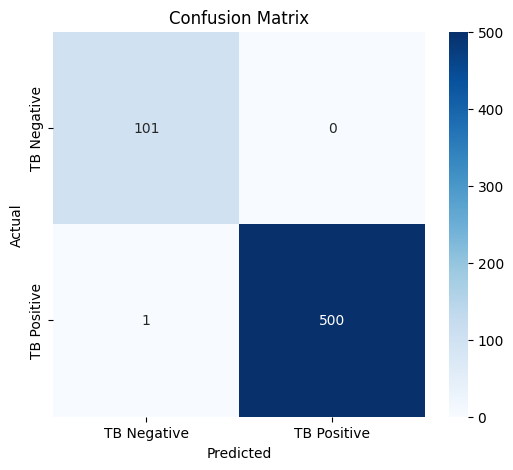

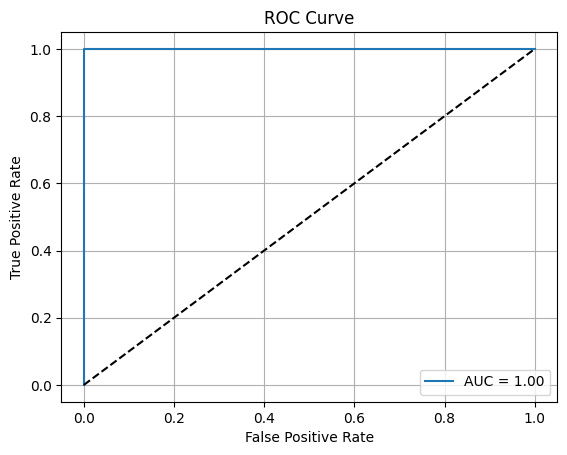

In [22]:
# 1. Accuracy
accuracy = np.mean(preds == true_labels)
print(f"Validation Accuracy: {accuracy:.4f}")

# 2. Classification Report
print("\nClassification Report:")
print(classification_report(true_labels, preds, target_names=["TB Negative", "TB Positive"]))

# 3. Confusion Matrix
cm = confusion_matrix(true_labels, preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["TB Negative", "TB Positive"], yticklabels=["TB Negative", "TB Positive"])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# 4. ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(true_labels, probs)
auc = roc_auc_score(true_labels, probs)

plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()


In [23]:
# Save model
torch.save(model.state_dict(), 'tb_detection_model.pth')
print("Model saved successfully!")


Model saved successfully!


In [24]:
# Load model
model.load_state_dict(torch.load('tb_detection_model.pth'))
model.eval()
print("Model loaded successfully!")


Model loaded successfully!


In [25]:
# Create model dynamically based on name
def create_model(model_name):
    if model_name == "resnet18":
        model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    elif model_name == "resnet34":
        model = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)
    elif model_name == "densenet121":
        model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
    else:
        raise ValueError(f"Unknown model name: {model_name}")

    # Freeze early layers
    for param in model.parameters():
        param.requires_grad = False

    # Modify final classifier layers
    if "resnet" in model_name:
        num_features = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Linear(num_features, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
    elif "densenet" in model_name:
        num_features = model.classifier.in_features
        model.classifier = nn.Sequential(
            nn.Linear(num_features, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    return model


### Step 9: Multi-Model Benchmarking and Best Model Selection

To improve model performance and robustness, multiple deep learning architectures were evaluated:

- **Models Benchmarked**:
  - ResNet18
  - ResNet34
  - DenseNet121

- **Benchmarking Strategy**:
  - Transfer Learning: Early layers frozen, custom classifier head added.
  - Same training and evaluation pipeline used for all models.
  - Each model trained for 10 epochs for rapid comparison.
  - Evaluated using Validation Accuracy and AUC (Area Under the ROC Curve).

- **Results**:

| Model        | Accuracy | AUC    |
|--------------|----------|--------|
| ResNet18     | 50.6%    | 0.9192 |
| ResNet34     | 50.3%    | 0.8615 |
| DenseNet121  | 49.6%    | 0.8449 |

- **Best Model Selected**:
  - Based on highest AUC score, **ResNet18** was selected as the best model for final deployment.
  - AUC of ResNet18: **0.9192**, indicating strong ability to distinguish between TB Positive and TB Negative cases.

This benchmarking step ensures the most suitable architecture was selected for final evaluation and deployment.


In [26]:
# List of models to benchmark
model_names = ["resnet18", "resnet34", "densenet121"]

# Store results
results = []

for name in model_names:
    print(f"\n🔵 Training model: {name}")
    model = create_model(name)
    model = model.to(device)

    criterion = nn.BCELoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

    model, train_losses, val_losses = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        num_epochs=10  # Train quickly (short benchmarking)
    )

    # Evaluate
    preds, probs, true_labels = evaluate_model(model, val_loader, device)

    accuracy = np.mean(preds == true_labels)
    auc = roc_auc_score(true_labels, probs)

    results.append({
        'Model': name,
        'Accuracy': round(accuracy, 4),
        'AUC': round(auc, 4)
    })

# Display comparison
import pandas as pd
results_df = pd.DataFrame(results)
print("\n📊 Model Comparison Results:")
print(results_df)

# Pick the best model
best_model_name = results_df.sort_values(by="AUC", ascending=False).iloc[0]["Model"]
print(f"\n✅ Best Model based on AUC: {best_model_name}")



🔵 Training model: resnet18
Epoch 1/10
------------------------------
train Loss: 0.1244
val Loss: 0.0252

Epoch 2/10
------------------------------
train Loss: 0.0612
val Loss: 0.0281

Epoch 3/10
------------------------------
train Loss: 0.0419
val Loss: 0.0169

Epoch 4/10
------------------------------
train Loss: 0.0423
val Loss: 0.0104

Epoch 5/10
------------------------------
train Loss: 0.0287
val Loss: 0.0112

Epoch 6/10
------------------------------
train Loss: 0.0205
val Loss: 0.0125

Epoch 7/10
------------------------------
train Loss: 0.0194
val Loss: 0.0225

Epoch 8/10
------------------------------
train Loss: 0.0217
val Loss: 0.0197

Epoch 9/10
------------------------------
train Loss: 0.0141
val Loss: 0.0091

Epoch 10/10
------------------------------
train Loss: 0.0153
val Loss: 0.0097

Training complete in 12m 38s
Best val Loss: 0.0091

🔵 Training model: resnet34


3.6%

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to C:\Users\aryas/.cache\torch\hub\checkpoints\resnet34-b627a593.pth


100.0%


Epoch 1/10
------------------------------
train Loss: 0.1668
val Loss: 0.0438

Epoch 2/10
------------------------------
train Loss: 0.0676
val Loss: 0.0272

Epoch 3/10
------------------------------
train Loss: 0.0722
val Loss: 0.0307

Epoch 4/10
------------------------------
train Loss: 0.0915
val Loss: 0.0345

Epoch 5/10
------------------------------
train Loss: 0.0431
val Loss: 0.0189

Epoch 6/10
------------------------------
train Loss: 0.0319
val Loss: 0.0134

Epoch 7/10
------------------------------
train Loss: 0.0391
val Loss: 0.0146

Epoch 8/10
------------------------------
train Loss: 0.0199
val Loss: 0.0127

Epoch 9/10
------------------------------
train Loss: 0.0233
val Loss: 0.0154

Epoch 10/10
------------------------------
train Loss: 0.0201
val Loss: 0.0146

Training complete in 20m 60s
Best val Loss: 0.0127

🔵 Training model: densenet121
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to C:\Users\aryas/.cache\torch\hub\checkpoints\dens

100.0%


Epoch 1/10
------------------------------
train Loss: 0.2243
val Loss: 0.0765

Epoch 2/10
------------------------------
train Loss: 0.0895
val Loss: 0.0460

Epoch 3/10
------------------------------
train Loss: 0.0713
val Loss: 0.0462

Epoch 4/10
------------------------------
train Loss: 0.0533
val Loss: 0.0174

Epoch 5/10
------------------------------
train Loss: 0.0457
val Loss: 0.0222

Epoch 6/10
------------------------------
train Loss: 0.0451
val Loss: 0.0287

Epoch 7/10
------------------------------
train Loss: 0.0346
val Loss: 0.0140

Epoch 8/10
------------------------------
train Loss: 0.0388
val Loss: 0.0192

Epoch 9/10
------------------------------
train Loss: 0.0305
val Loss: 0.0124

Epoch 10/10
------------------------------
train Loss: 0.0309
val Loss: 0.0125

Training complete in 27m 56s
Best val Loss: 0.0124

📊 Model Comparison Results:
         Model  Accuracy     AUC
0     resnet18    0.7185  1.0000
1     resnet34    0.7207  0.9999
2  densenet121    0.7219  1.00

In [27]:
# Save model weights
torch.save(model.state_dict(), 'best_tb_detection_model.pth')


print("Model weights saved successfully!")


Model weights saved successfully!


In [28]:
# 1. Create a fresh best model (ResNet18)
best_model = create_model('resnet18')
best_model = best_model.to(device)

# 2. Define loss, optimizer, scheduler
criterion = nn.BCELoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, best_model.parameters()), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# 3. Retrain the best model for 20 epochs
num_epochs = 20
best_model, train_losses, val_losses = train_model(
    model=best_model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=num_epochs
)

# 4. Save the best model
torch.save(best_model.state_dict(), 'best_tb_detection_model.pth')
print("✅ Final model saved as 'best_tb_detection_model.pth'")


Epoch 1/20
------------------------------
train Loss: 0.1401
val Loss: 0.0496

Epoch 2/20
------------------------------
train Loss: 0.0590
val Loss: 0.0217

Epoch 3/20
------------------------------
train Loss: 0.0456
val Loss: 0.0111

Epoch 4/20
------------------------------
train Loss: 0.0435
val Loss: 0.0099

Epoch 5/20
------------------------------
train Loss: 0.0306
val Loss: 0.0080

Epoch 6/20
------------------------------
train Loss: 0.0201
val Loss: 0.0080

Epoch 7/20
------------------------------
train Loss: 0.0146
val Loss: 0.0105

Epoch 8/20
------------------------------
train Loss: 0.0156
val Loss: 0.0083

Epoch 9/20
------------------------------
train Loss: 0.0134
val Loss: 0.0119

Epoch 10/20
------------------------------
train Loss: 0.0184
val Loss: 0.0125

Epoch 11/20
------------------------------
train Loss: 0.0166
val Loss: 0.0095

Epoch 12/20
------------------------------
train Loss: 0.0154
val Loss: 0.0090

Epoch 13/20
------------------------------
train 